### Imports

In [1]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import loguniform, randint
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Machine Learning and Data Processing
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    roc_curve,
    auc,
    classification_report,
    confusion_matrix,
    RocCurveDisplay,
    precision_recall_fscore_support
)

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

# Plotting setup
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


In [2]:
application_src = r"C:\Users\james\OneDrive\Desktop\Applications\Lendela\application.csv"
offers_src = r"C:\Users\james\OneDrive\Desktop\Applications\Lendela\offers.csv"

applications = pd.read_csv(application_src)
offers = pd.read_csv(offers_src)

pd.set_option('display.max_columns', None, 'max_colwidth', None, 'display.expand_frame_repr', False)

### Preliminary Data Transformation (Data Cleaning)

#### NAN Values

In [3]:
print("Applications shape: {}".format(applications.shape))
print("Applications NaN Count")
print(applications.isna().sum().sort_values(ascending=False))
print("Offers shape: {}".format(offers.shape))
print("Offers NaN Count")
print(offers.isna().sum().sort_values(ascending=False))

Applications shape: (3692, 14)
Applications NaN Count
salesName             62
jobIndustry            7
applic_status_name     0
age                    0
appliedAmount          0
civilStatus            0
loanPurpose            0
monthlyIncome          0
nationality            0
residency              0
workStatus             0
applicationTime        0
appId                  0
leadSource             0
dtype: int64
Offers shape: (131665, 8)
Offers NaN Count
disburseTime         131055
offerChosenTime      129642
offerGivenTime       106064
pendingOfferTime      70474
offer_status_name         0
lenderName                0
appId                     0
offerId                   0
dtype: int64


The 69 NaN values from Applications.csv come either from a missing sales person, or the two workStatus - unemployed, retired

In [4]:
applications[applications["workStatus"].isin(["unemployed", "retired"])]

,salesName,applic_status_name,age,appliedAmount,civilStatus,loanPurpose,monthlyIncome,nationality,residency,workStatus,jobIndustry,applicationTime,appId,leadSource
7,Sales rep F,Closed App,40,50000.0,married,debt-consolidation-ff,4500.0,LB,ep,unemployed,NaN,2022-01-04 01:27:15.397,App 0008,facebook
1231,Sales rep F,Closed App,75,14000.0,married,renovation,2000.0,SG,s,retired,NaN,2022-02-02 18:04:54.606,App 1232,direct
1330,Sales rep I,Bank Declined App,49,20000.0,married,paying-bills,3500.0,SG,s,retired,NaN,2022-02-05 02:34:56.674,App 1331,facebook
2411,Sales rep F,Bank Declined App,22,1500.0,single,paying-bills,2500.0,SG,s,unemployed,NaN,2022-03-03 06:49:31.51,App 2412,facebook
3442,Sales rep I,Bank Declined App,39,30000.0,single,debt-consolidation,4000.0,SG,s,unemployed,NaN,2022-03-26 18:44:36.664,App 3443,facebook
3508,Sales rep F,Bank Declined App,35,140000.0,married,paying-bills,2000.0,SG,s,unemployed,NaN,2022-03-28 11:16:32.553,App 3509,nestia
3666,Sales rep F,Closed App,39,20000.0,single,other,2000.0,SG,s,unemployed,NaN,2022-03-31 15:40:37.483,App 3667,yahoo


Removing 69/3692 application data is considered negligible, percentage wise. <br> 
Since most of the NaN values come from the Time columns in the offer dataset, remove them for simplicity. 

In [5]:
app_clean = applications.dropna().reset_index().drop(columns=['index'])
print("Applications shape: {}".format(app_clean.shape))
print("Applications NaN Count")
print(app_clean.isna().sum().sort_values(ascending=False))

offers_clean = offers.drop(columns=["pendingOfferTime","offerGivenTime","offerChosenTime","disburseTime"])
print("Offers shape: {}".format(offers_clean.shape))
print("Offers NaN Count")
print(offers_clean.isna().sum().sort_values(ascending=False))

Applications shape: (3623, 14)
Applications NaN Count
salesName             0
applic_status_name    0
age                   0
appliedAmount         0
civilStatus           0
loanPurpose           0
monthlyIncome         0
nationality           0
residency             0
workStatus            0
jobIndustry           0
applicationTime       0
appId                 0
leadSource            0
dtype: int64
Offers shape: (131665, 4)
Offers NaN Count
offer_status_name    0
lenderName           0
appId                0
offerId              0
dtype: int64


So now app_clean and offers_clean are the cleaned datasets with no missing values

In [6]:
print("\n ***** Applications no NaN ***** \n")
print(app_clean.sort_values(by = 'appId').head())
print("\n ***** Offers no NaN ***** \n")
print(offers_clean.sort_values(by = 'appId').head())


 ***** Applications no NaN ***** 

      salesName applic_status_name  age  appliedAmount civilStatus         loanPurpose  monthlyIncome nationality residency       workStatus jobIndustry          applicationTime     appId leadSource
0  Sales rep  C        Expired App   51        60000.0     married  business-expansion         6200.0          SG         s    self-employed      retail  2022-01-05 14:37:25.759  App 0003     e-mail
1  Sales rep  C        Expired App   52        10000.0     married  debt-consolidation         3120.0          SG         s  employed-salary  government  2022-01-07 23:13:56.093  App 0004     google
2  Sales rep  C         Closed App   33         2000.0     married        paying-bills         3400.0          SG         s  employed-salary    it-telco  2022-01-05 19:28:59.264  App 0005     google
3  Sales rep  F         Closed App   31        40000.0     married  debt-consolidation         4250.0          SG         s  employed-salary  government  2022-01-20 13:

The unique joining key for the datasets is "appId". Use this to join the datasets into one for training later. The individual datasets can still be looked at for visualisations.

In [7]:
lender_amounts = pd.merge(app_clean, offers_clean, on='appId').sort_values(by=["appId", "offer_status_name"])

print(lender_amounts.shape)

lender_amounts.head()

(129274, 17)


,salesName,applic_status_name,age,appliedAmount,civilStatus,loanPurpose,monthlyIncome,nationality,residency,workStatus,jobIndustry,applicationTime,appId,leadSource,offer_status_name,lenderName,offerId
0,Sales rep C,Expired App,51,60000.0,married,business-expansion,6200.0,SG,s,self-employed,retail,2022-01-05 14:37:25.759,App 0003,e-mail,Bank Approved IPA,Lender 32,08680203
1,Sales rep C,Expired App,51,60000.0,married,business-expansion,6200.0,SG,s,self-employed,retail,2022-01-05 14:37:25.759,App 0003,e-mail,Bank Approved IPA,Lender 33,08680202
4,Sales rep C,Expired App,51,60000.0,married,business-expansion,6200.0,SG,s,self-employed,retail,2022-01-05 14:37:25.759,App 0003,e-mail,Bank Approved IPA,Lender 02,a38c73e7
7,Sales rep C,Expired App,51,60000.0,married,business-expansion,6200.0,SG,s,self-employed,retail,2022-01-05 14:37:25.759,App 0003,e-mail,Bank Approved IPA,Lender 05,a38c73e4
11,Sales rep C,Expired App,51,60000.0,married,business-expansion,6200.0,SG,s,self-employed,retail,2022-01-05 14:37:25.759,App 0003,e-mail,Bank Approved IPA,Lender 09,a38c73de


The offer_status_name column has one erroneous string: "\n                       Chosen - Lender Review"

In [8]:
lender_amounts[lender_amounts["offer_status_name"].str.contains("Review", na=False)]

,salesName,applic_status_name,age,appliedAmount,civilStatus,loanPurpose,monthlyIncome,nationality,residency,workStatus,jobIndustry,applicationTime,appId,leadSource,offer_status_name,lenderName,offerId
32085,Sales rep F,Expired App,43,25000.0,divorced,debt-consolidation,5500.0,SG,s,employed-salary,building-construction,2022-01-24 20:17:42.895,App 0937,bing,Chosen - Manual Review,Lender 24,c21f6a22
38076,Sales rep I,Closed App,43,1000.0,divorced,debt-consolidation-ff,2680.0,SG,s,other,logistic,2022-01-29 11:30:16.434,App 1111,facebook,\n Chosen - Lender Review,Lender 04,cb99e62e
38188,Sales rep I,Closed App,34,10000.0,single,special-occasion,3000.0,SG,s,self-employed,f-and-b,2022-01-29 13:58:55.685,App 1114,direct,\n Chosen - Lender Review,Lender 08,cb99eeb5
101442,Sales rep C,Closed App,46,20000.0,single,investment,2896.0,SG,s,employed-salary,building-construction,2022-03-14 17:00:50.72,App 2894,facebook,\n Chosen - Lender Review,Lender 08,99262afb
110862,Sales rep I,Closed App,23,20000.0,single,debt-consolidation-ff,5000.0,SG,s,self-employed,insurance,2022-03-20 06:39:39.957,App 3165,google,\n Chosen - Lender Review,Lender 32,ce4f066e
115829,Sales rep I,Closed App,52,10000.0,married,credit-card-debt,20600.0,SG,s,employed-salary,it-telco,2022-03-23 14:14:24.464,App 3307,google,\n Chosen - Lender Review,Lender 29,b976cda4
128529,Sales rep C,Closed App,45,9000.0,single,debt-consolidation-ff,8400.0,PH,ep,employed-salary,it-telco,2022-03-31 16:34:54.138,App 3672,wa,\n Chosen - Lender Review,Lender 11,802fea2f


In [9]:
lender_amounts['offer_status_name'] = lender_amounts['offer_status_name'].str.strip()
lender_amounts[lender_amounts["offer_status_name"].str.contains("Review", na=False)]

,salesName,applic_status_name,age,appliedAmount,civilStatus,loanPurpose,monthlyIncome,nationality,residency,workStatus,jobIndustry,applicationTime,appId,leadSource,offer_status_name,lenderName,offerId
32085,Sales rep F,Expired App,43,25000.0,divorced,debt-consolidation,5500.0,SG,s,employed-salary,building-construction,2022-01-24 20:17:42.895,App 0937,bing,Chosen - Manual Review,Lender 24,c21f6a22
38076,Sales rep I,Closed App,43,1000.0,divorced,debt-consolidation-ff,2680.0,SG,s,other,logistic,2022-01-29 11:30:16.434,App 1111,facebook,Chosen - Lender Review,Lender 04,cb99e62e
38188,Sales rep I,Closed App,34,10000.0,single,special-occasion,3000.0,SG,s,self-employed,f-and-b,2022-01-29 13:58:55.685,App 1114,direct,Chosen - Lender Review,Lender 08,cb99eeb5
101442,Sales rep C,Closed App,46,20000.0,single,investment,2896.0,SG,s,employed-salary,building-construction,2022-03-14 17:00:50.72,App 2894,facebook,Chosen - Lender Review,Lender 08,99262afb
110862,Sales rep I,Closed App,23,20000.0,single,debt-consolidation-ff,5000.0,SG,s,self-employed,insurance,2022-03-20 06:39:39.957,App 3165,google,Chosen - Lender Review,Lender 32,ce4f066e
115829,Sales rep I,Closed App,52,10000.0,married,credit-card-debt,20600.0,SG,s,employed-salary,it-telco,2022-03-23 14:14:24.464,App 3307,google,Chosen - Lender Review,Lender 29,b976cda4
128529,Sales rep C,Closed App,45,9000.0,single,debt-consolidation-ff,8400.0,PH,ep,employed-salary,it-telco,2022-03-31 16:34:54.138,App 3672,wa,Chosen - Lender Review,Lender 11,802fea2f


Lender 10 below actually has two offers for all their applications, due to having two offer_status_names, either same, or different ones. Some examples are listed below. <br>
The complete list of combinations are also below.

In [10]:
from itertools import combinations

# Filter for rows where lenderName is "Lender 10" and sort by appId
lender_10_rows = lender_amounts[lender_amounts["lenderName"] == "Lender 10"][["appId", "offer_status_name", "lenderName", "offerId"]].sort_values(by="appId")

# Display the first 10 rows
print(lender_10_rows.head())
print("\n ******************************************** \n")

# Filter for (appId, lenderName) groups with two or more entries
lender10_groups = lender_amounts.groupby(["appId", "lenderName"]).filter(lambda x: len(x) >= 2)

# Dictionary to store each unique combination of offer_status_name with a sample (appId, lenderName)
combo_appid_lender_dict = {}

# Group by appId and lenderName and find unique combinations of offer_status_name
for (app_id, lender_name), group in lender10_groups.groupby(["appId", "lenderName"]):
    offer_status_names = group["offer_status_name"].unique()
    # Get all combinations of offer_status_names for this (appId, lenderName) group
    for combo in combinations(offer_status_names, 2):
        sorted_combo = tuple(sorted(combo))
        # If this combination isn't already in the dictionary, add it with the current (app_id, lender_name)
        if sorted_combo not in combo_appid_lender_dict:
            combo_appid_lender_dict[sorted_combo] = (app_id, lender_name)

# Print the dictionary
for combo, sample_appid_lender in combo_appid_lender_dict.items():
    print(f"{combo}: {sample_appid_lender}")

       appId  offer_status_name lenderName   offerId
12  App 0003             Queued  Lender 10  a38c73dd
13  App 0003             Queued  Lender 10  a38c73dc
48  App 0004  Bank Declined IPA  Lender 10  8547deda
47  App 0004             Queued  Lender 10  8547dedb
81  App 0005             Queued  Lender 10  ca79c52f

 ******************************************** 

('Bank Declined IPA', 'Queued'): ('App 0004', 'Lender 10')
('Pending IPA', 'Queued'): ('App 0013', 'Lender 10')
('Bank Approved IPA', 'Queued'): ('App 0028', 'Lender 10')
('Loan Disbursed IPA/LG', 'Queued'): ('App 0029', 'Lender 10')
('Loan Rejected - Post', 'Queued'): ('App 0352', 'Lender 10')
('Bank Approved IPA', 'Bank Declined IPA'): ('App 0760', 'Lender 10')
('Customer Reject IPA/LG', 'Queued'): ('App 1328', 'Lender 10')
('Acknowledged', 'Queued'): ('App 1744', 'Lender 10')
('Loan Rejected - Pre', 'Queued'): ('App 2429', 'Lender 10')


We remove this by two steps:
* Step 1: Even if offerId is different, if the appId, lenderName, and offer_status_name are the same, remove a duplicate.
* Step 2: For the remainder, all pairings of different offer_status_name for the same appId include a ("Queued"), remove this row. <br> 
* Step 2.1: There is only one exception for the ("Bank Accepted IPA", "Bank Declined IPA" combination)

In [11]:
# Step 1: Remove exact duplicate records
lender_data_cleaned = lender_amounts[lender_amounts["lenderName"] == "Lender 10"].drop_duplicates(subset=['appId', 'lenderName', 'offer_status_name'])

# Step 2 and Step 2.1: Define a function to select the preferred offer_status_name for each appId group
def select_preferred_status(statuses):
    if 'Queued' in statuses:
        return statuses[statuses != 'Queued'][0] if len(statuses[statuses != 'Queued']) > 0 else 'Queued'
    elif 'Bank Declined IPA' in statuses:
        return 'Bank Declined IPA'
    else:
        return statuses[0]  # If neither "Queued" nor "Bank Declined IPA" are present, take any other status

lender_data_filtered = (
    lender_data_cleaned.groupby("appId")
    .apply(lambda x: x[x["offer_status_name"] == select_preferred_status(x["offer_status_name"].values)])
    .reset_index(drop=True)
)

# Display the cleaned and filtered data
print(lender_data_filtered)

         salesName  applic_status_name  age  appliedAmount civilStatus         loanPurpose  monthlyIncome nationality residency       workStatus            jobIndustry          applicationTime     appId        leadSource  offer_status_name lenderName   offerId
0     Sales rep  C         Expired App   51        60000.0     married  business-expansion         6200.0          SG         s    self-employed                 retail  2022-01-05 14:37:25.759  App 0003            e-mail             Queued  Lender 10  a38c73dd
1     Sales rep  C         Expired App   52        10000.0     married  debt-consolidation         3120.0          SG         s  employed-salary             government  2022-01-07 23:13:56.093  App 0004            google  Bank Declined IPA  Lender 10  8547deda
2     Sales rep  C          Closed App   33         2000.0     married        paying-bills         3400.0          SG         s  employed-salary               it-telco  2022-01-05 19:28:59.264  App 0005            goo

Combine the data back - lender2use is the complete application-offer combination dataset to use.

In [12]:
# Step 1: Filter out original rows for "Lender 10" from the full dataset
all_lenders_except_10 = lender_amounts[lender_amounts["lenderName"] != "Lender 10"]

# Step 2: Concatenate the cleaned "Lender 10" data with the remaining data
lender2use = pd.concat([all_lenders_except_10, lender_data_filtered], ignore_index=True)

# Display the final combined dataset
print(lender2use)

           salesName  applic_status_name  age  appliedAmount civilStatus         loanPurpose  monthlyIncome nationality residency       workStatus            jobIndustry          applicationTime     appId        leadSource  offer_status_name lenderName   offerId
0       Sales rep  C         Expired App   51        60000.0     married  business-expansion         6200.0          SG         s    self-employed                 retail  2022-01-05 14:37:25.759  App 0003            e-mail  Bank Approved IPA  Lender 32  08680203
1       Sales rep  C         Expired App   51        60000.0     married  business-expansion         6200.0          SG         s    self-employed                 retail  2022-01-05 14:37:25.759  App 0003            e-mail  Bank Approved IPA  Lender 33  08680202
2       Sales rep  C         Expired App   51        60000.0     married  business-expansion         6200.0          SG         s    self-employed                 retail  2022-01-05 14:37:25.759  App 0003       

### Exploratory Data Analysis (Data Visualisations)

We can first look at the distribution of offer types by lender, but since there are too many offer_statuses, we can approach this by simplifying the offer_statuses into four categories:
* Approved Offers
* Declined Offers (by Bank or by Customer or by System)
* Pending Offers
* Offers selected for review

In [13]:
lender2eda = lender2use.copy()

status_mapping = {
    'Bank Approved IPA': 'Approved',
    'Loan Disbursed IPA/LG': 'Approved',
    'Bank Declined IPA': 'Declined',
    'Customer Reject IPA/LG': 'Declined',
    'PR Fail IPA/LG': 'Declined',
    'Loan Rejected - Pre': 'Declined',
    'Loan Rejected - Post': 'Declined',
    'Queued': 'Pending',
    'Pending IPA': 'Pending',
    'Acknowledged': 'Pending',
    'Chosen - Manual Review': 'Review',
    'Chosen - Lender Review': 'Review'
}

# Create a new column for the simplified categories
lender2eda['status_category'] = lender2eda['offer_status_name'].map(status_mapping)

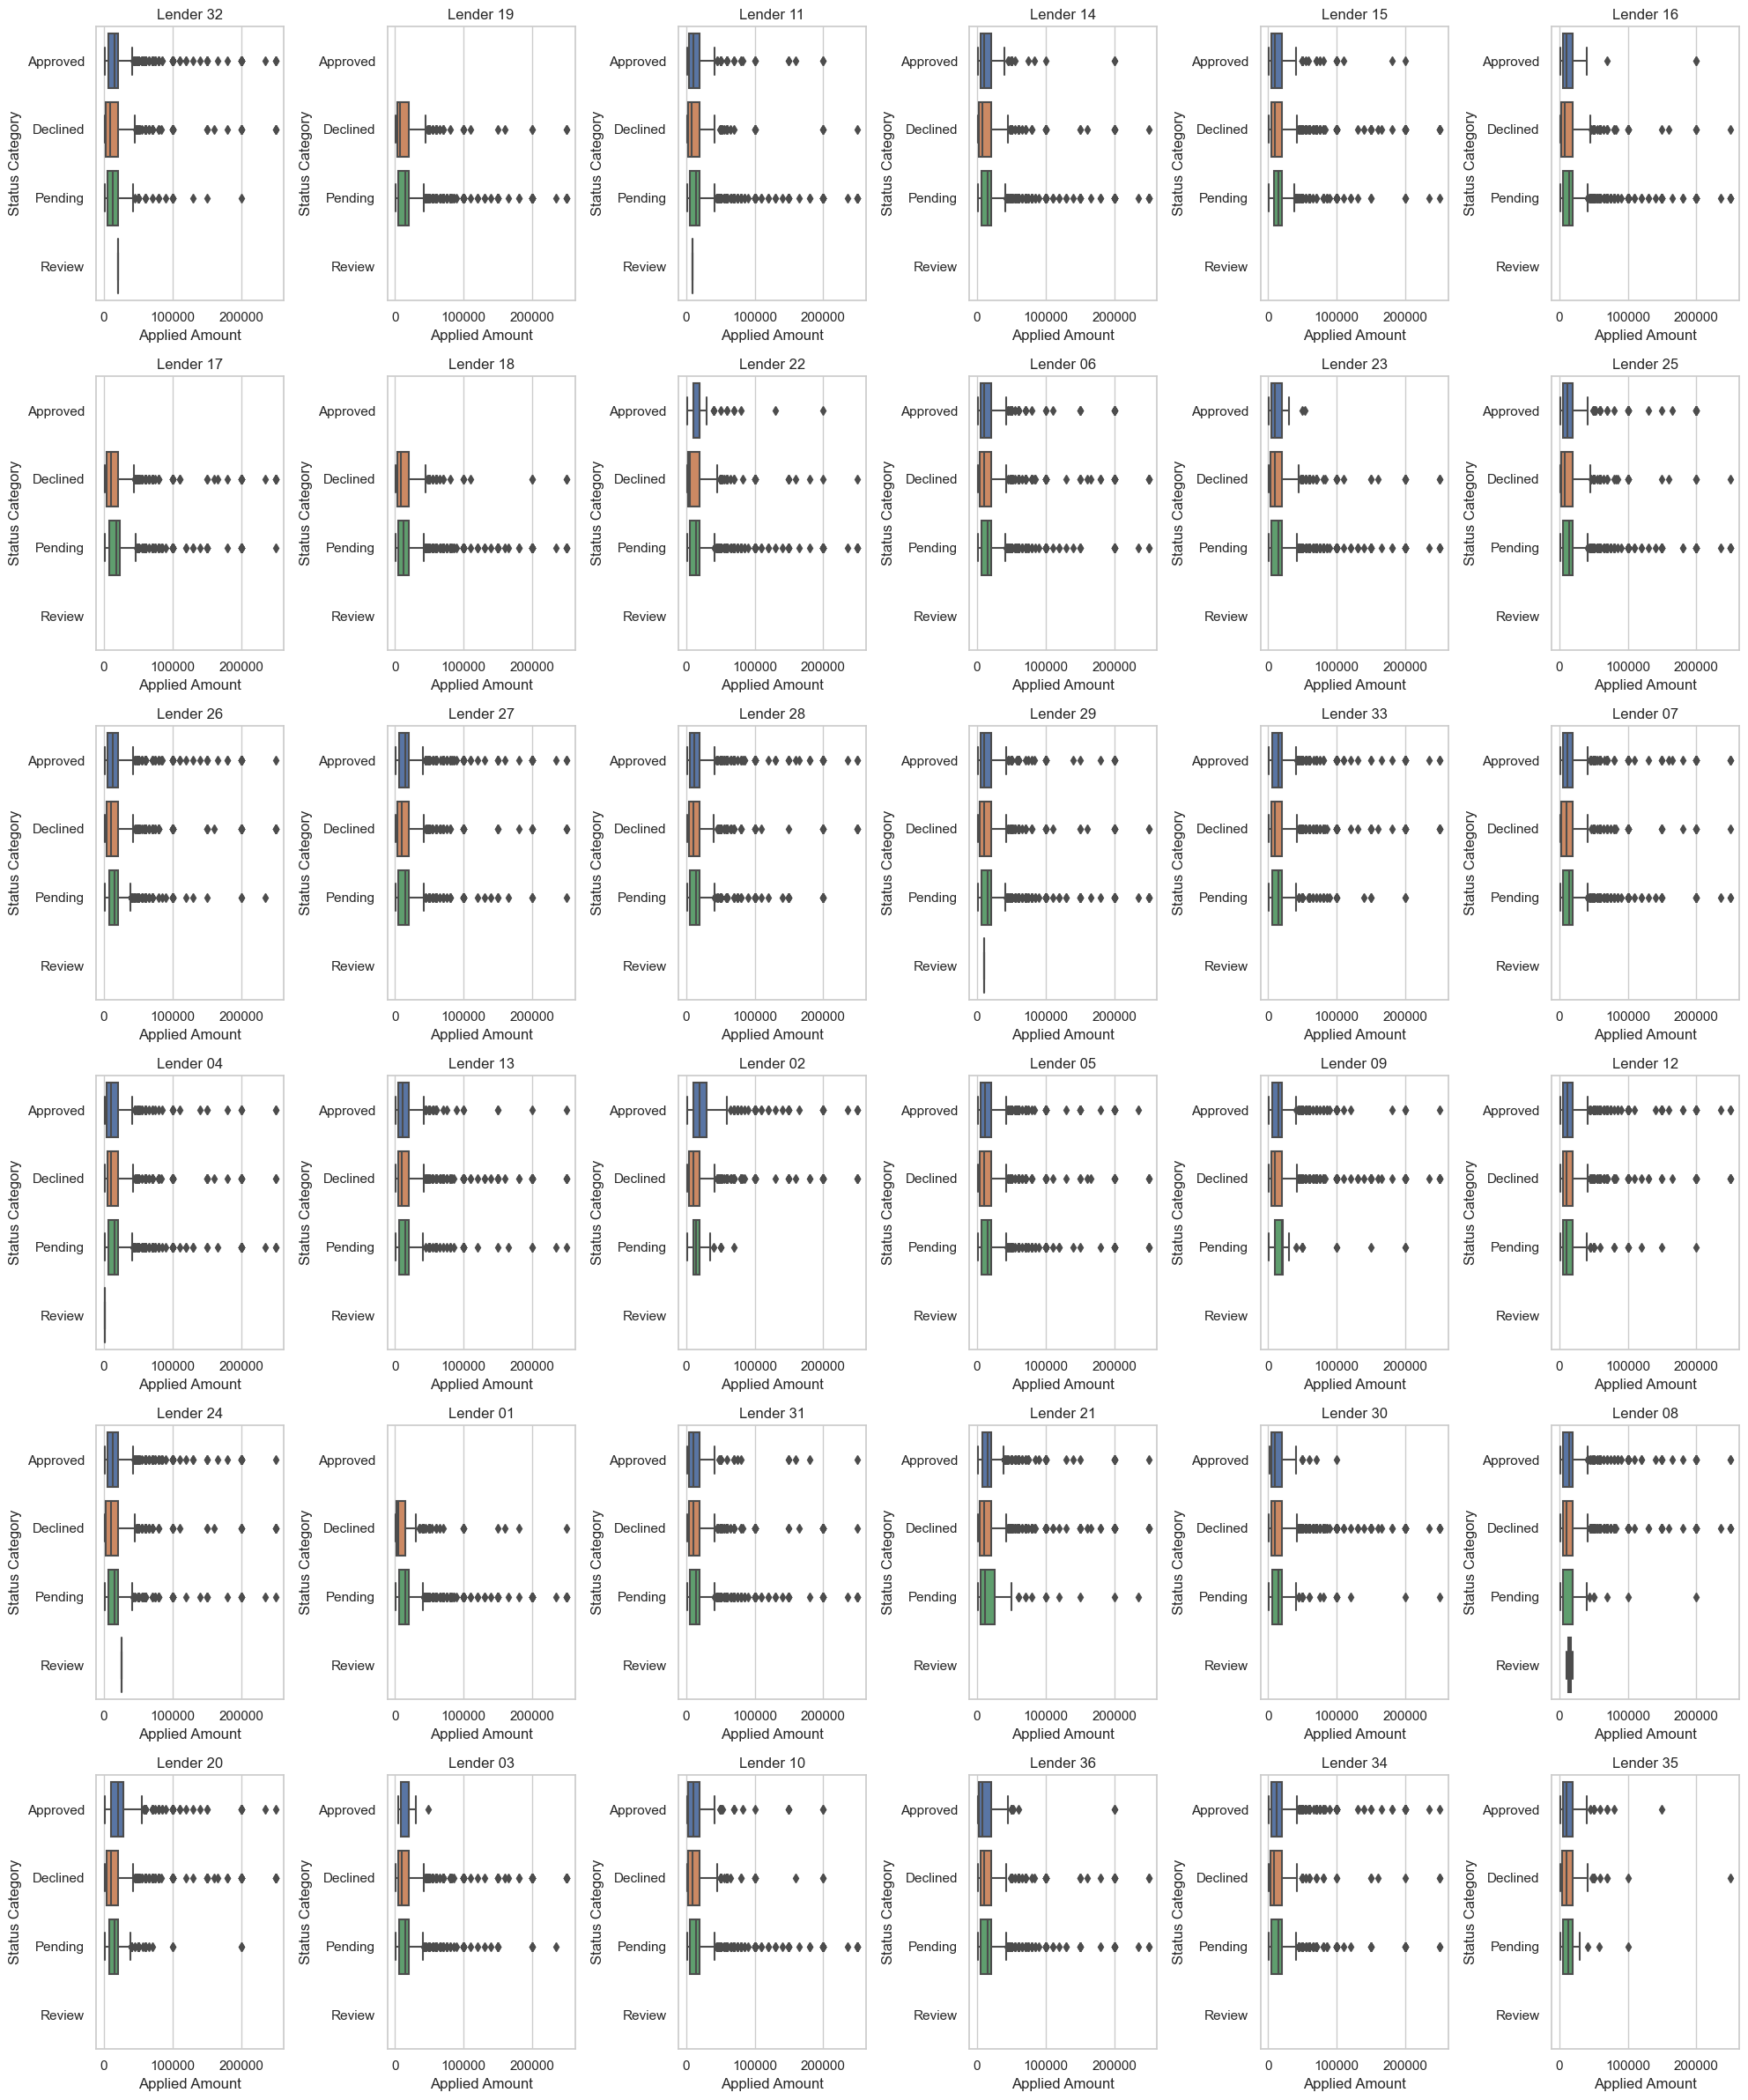

In [14]:
# Define the order for the status_category
status_order = ['Approved', 'Declined', 'Pending', 'Review']

# Get unique lenders with data
lenders_with_data = lender2eda['lenderName'].value_counts()[lender2eda['lenderName'].value_counts() > 0].index.tolist()

# Set up the subplot grid
num_lenders = len(lenders_with_data)
rows = num_lenders // 6 + (num_lenders % 6 > 0)  # Calculate rows needed
fig, axes = plt.subplots(nrows=rows, ncols=6, figsize=(20, rows * 4))
axes = axes.flatten()  # Flatten the 2D array of axes

# Loop through each lender and create a plot
for i, lender in enumerate(lenders_with_data):
    # Filter the data for the current lender
    lender_data = lender2eda[lender2eda['lenderName'] == lender]

    # Check which status categories are present for the current lender
    present_statuses = lender_data['status_category'].unique()
    
    # Create a boxplot for the appliedAmount with status_category as hue
    sns.boxplot(data=lender_data, x='appliedAmount', y='status_category', ax=axes[i], order=status_order)
    
    # Set the title for each subplot
    axes[i].set_title(lender)
    axes[i].set_xlabel('Applied Amount')
    axes[i].set_ylabel('Status Category')

# Remove any empty subplots (if there are fewer than 36 lenders with data)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

In [53]:
print(lender2eda[lender2eda["status_category"]=="Review"])
print(offers[offers["offer_status_name"].str.contains("Review", na=False)])
print(applications[applications["appId"].isin(["App 3672", "App 3307", "App 3165", "App 2894" ,"App 1114" ,"App 1111", "App 0937"])])

offers.offer_status_name.unique()

           salesName applic_status_name  age  appliedAmount civilStatus            loanPurpose  monthlyIncome nationality residency       workStatus            jobIndustry          applicationTime     appId leadSource       offer_status_name lenderName   offerId status_category
30266   Sales rep  F        Expired App   43        25000.0    divorced     debt-consolidation         5500.0          SG         s  employed-salary  building-construction  2022-01-24 20:17:42.895  App 0937       bing  Chosen - Manual Review  Lender 24  c21f6a22          Review
35916   Sales rep  I         Closed App   43         1000.0    divorced  debt-consolidation-ff         2680.0          SG         s            other               logistic  2022-01-29 11:30:16.434  App 1111   facebook  Chosen - Lender Review  Lender 04  cb99e62e          Review
36018   Sales rep  I         Closed App   34        10000.0      single       special-occasion         3000.0          SG         s    self-employed               

array(['Queued', 'Bank Approved IPA', 'Bank Declined IPA', 'Pending IPA', 'Loan Disbursed IPA/LG', 'PR Fail IPA/LG', 'Customer Reject IPA/LG', 'Loan Rejected - Post', 'Loan Rejected - Pre', '\n                       Chosen - Lender Review', 'Acknowledged', 'Chosen - Manual Review'], dtype=object)

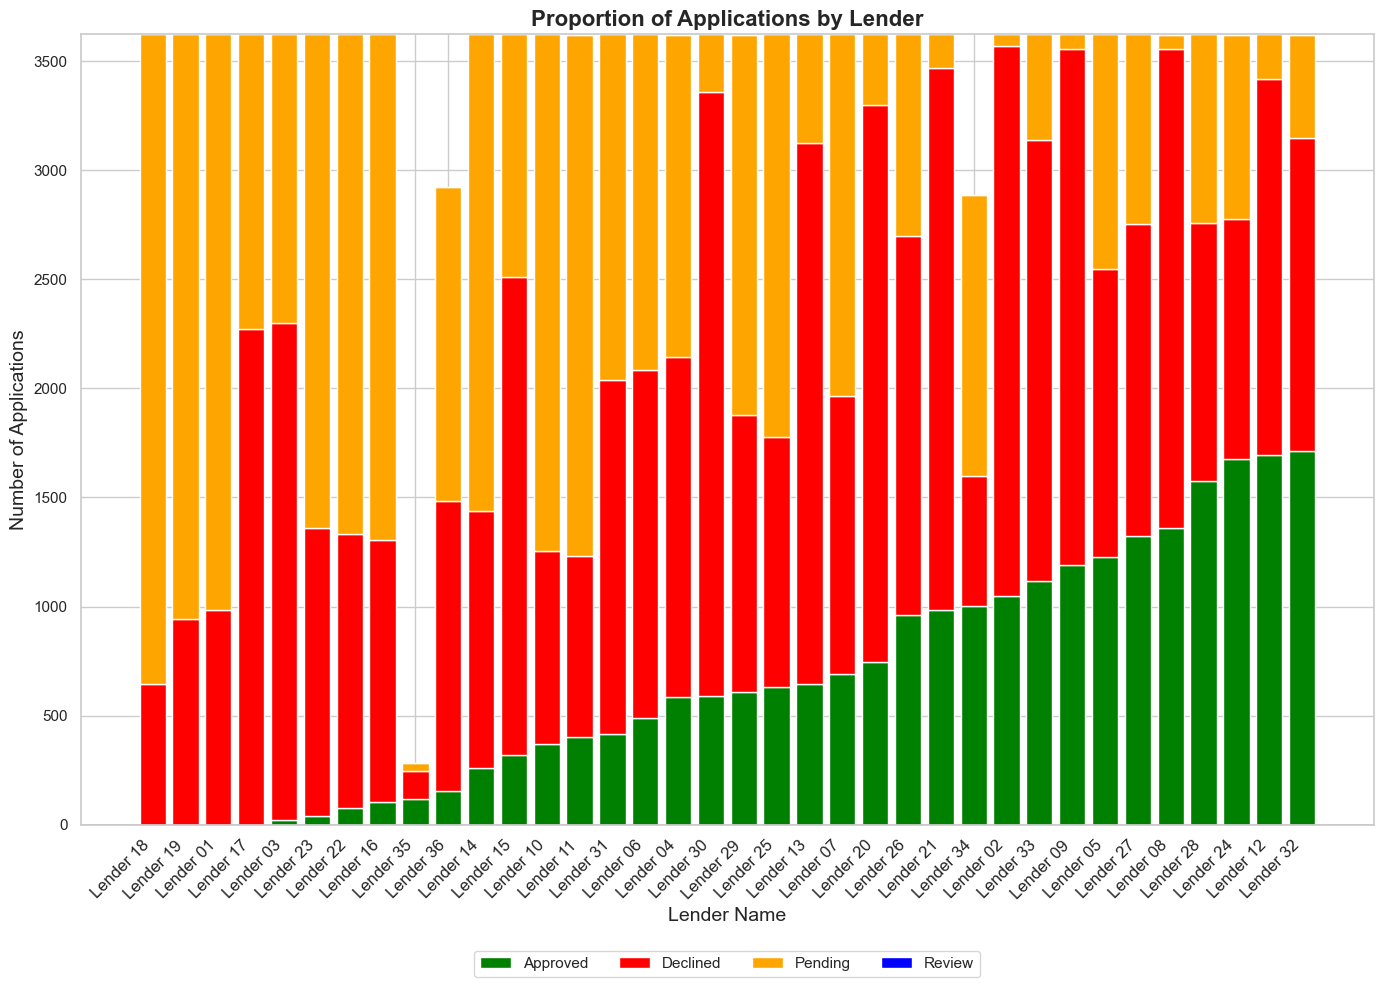

In [16]:
lender_stats = lender2eda.groupby('lenderName').agg(
    total_applications=('status_category', 'count'),
    approved_applications=('status_category', lambda x: (x == 'Approved').sum()),
    declined_applications=('status_category', lambda x: (x == 'Declined').sum()),
    pending_applications=('status_category', lambda x: (x == 'Pending').sum()),
    review_applications=('status_category', lambda x: (x == 'Review').sum())
).reset_index()

# Step 2: Sort lenders by total applications, then approved, then declined in ascending order
lender_stats_sorted = lender_stats.sort_values(
    by=['approved_applications', 'total_applications', 'declined_applications'],
    ascending=True
)

# Step 3: Prepare data for plotting
lender_names = lender_stats_sorted['lenderName']
approved_counts = lender_stats_sorted['approved_applications']
declined_counts = lender_stats_sorted['declined_applications']
pending_counts = lender_stats_sorted['pending_applications']
review_counts = lender_stats_sorted['review_applications']

# Step 4: Create a stacked bar plot with adjustments
plt.figure(figsize=(14, 10))  # Increase the figure size

# Create the stacked bar plot
plt.bar(lender_names, approved_counts, label='Approved', color='green')
plt.bar(lender_names, declined_counts, bottom=approved_counts, label='Declined', color='red')
plt.bar(lender_names, pending_counts, bottom=approved_counts + declined_counts, label='Pending', color='orange')
plt.bar(lender_names, review_counts, bottom=approved_counts + declined_counts + pending_counts, label='Review', color='blue')

# Customizing the plot
plt.title('Proportion of Applications by Lender', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Lender Name', fontsize=14)
plt.ylabel('Number of Applications', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x labels for better readability

# Underline the title
plt.gca().set_title(plt.gca().get_title(), fontsize=16, fontweight='bold')  # Set title with specific attributes
plt.axhline(y=0, color='black', linewidth=1)  # Add a line under the title
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)  # Adjust position of legend
plt.tight_layout()

# Display the plot
plt.show()

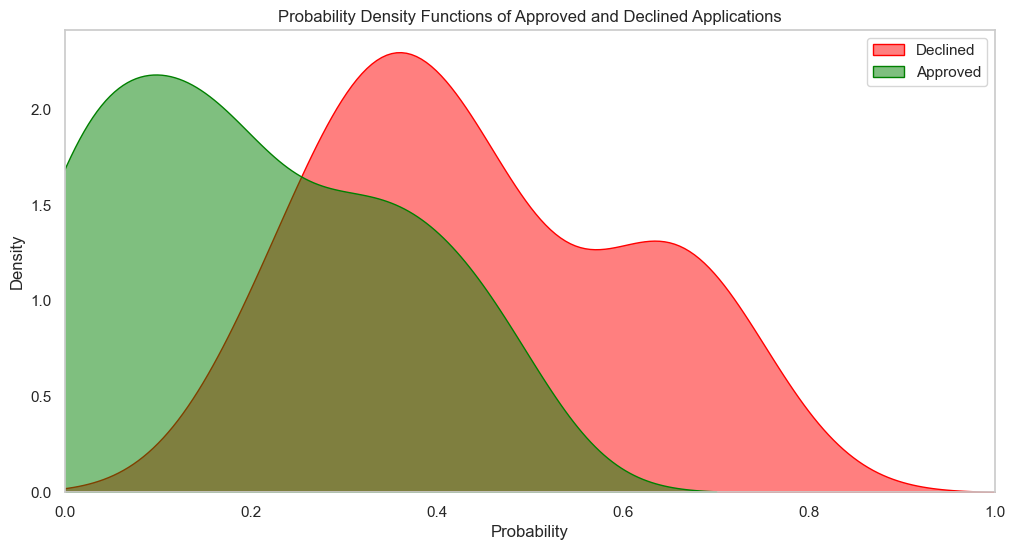

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming lender2eda is your DataFrame and 'status_category' contains the status information

# Step 1: Count total applications, approved applications, and declined applications by lender
lender_stats = lender2eda.groupby('lenderName').agg(
    total_applications=('status_category', 'count'),
    approved_applications=('status_category', lambda x: (x == 'Approved').sum()),
    declined_applications=('status_category', lambda x: (x == 'Declined').sum())
).reset_index()

# Step 2: Calculate the probability of declined and approved applications
lender_stats['probability_declined'] = lender_stats['declined_applications'] / lender_stats['total_applications']
lender_stats['probability_approved'] = lender_stats['approved_applications'] / lender_stats['total_applications']

# Step 3: Prepare Data for Plotting
# Create separate DataFrames for the two probabilities
data_declined = lender_stats[['lenderName', 'probability_declined']]
data_declined['status'] = 'Declined'

data_approved = lender_stats[['lenderName', 'probability_approved']]
data_approved['status'] = 'Approved'

# Concatenate the two DataFrames
data = pd.concat([data_declined, data_approved], ignore_index=True)

# Step 4: Plot the PDFs
plt.figure(figsize=(12, 6))
sns.kdeplot(data=data[data['status'] == 'Declined']['probability_declined'], label='Declined', fill=True, color='red', alpha=0.5)
sns.kdeplot(data=data[data['status'] == 'Approved']['probability_approved'], label='Approved', fill=True, color='green', alpha=0.5)

# Customize the plot
plt.title('Probability Density Functions of Approved and Declined Applications')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.xlim(0, 1)  # Limit x-axis from 0 to 1 since probabilities range from 0 to 1
plt.show()

### Pre-processing Pipeline for all applications

In [20]:
''' 
Columns related to sales 
'salesName'
'leadSource'

Columns related to application
'appId'                     - Individual application ID
'offerId'                   - Individual offer ID
'applic_status_name'        - Overall latest application status - ['Expired App', 'Closed App', 'Loan Disbursed App', 'Bank Declined App']
'lenderName'                - Individual lender name
'offer_status_name'         - Individual lender offer status
'appliedAmount'             - Amount of loan applied
'loanPurpose'               - Purpose of loan applied - [
                                'business-expansion', 'debt-consolidation', 'paying-bills', 'credit-card-debt', 'other', 'debt-consolidation-ff', 'home',
                                'renovation', 'wedding', 'medical', 'investment', 'car', 'line-of-credit', 'special-occasion', 'education', 'hobbies', 'vacation'
                                ]

Columns related to applicant
'age'                       - Age of applicant
'civilStatus'               - Civil Status of Applicant - ['married', 'single', 'divorced', 'widow']
'monthlyIncome'             - Monthly Income of Applicant (Numeric)
'nationality'               - Nationality of Applicant
'residency'                 - Residency of Applicant - ['s', 'pr', 'spass-wp', 'ep', 'ltvp'] 
                            - meaning "Citizen", "Employment Pass", "Permanent Resident", "Singpass Work Permit", "Long Term Visitor Pass"
'workStatus'                - Employment Type of Applicant - ['self-employed', 'employed-salary', 'other', 'employed-contract', 'student', 'national-serviceman']
'jobIndustry'               - Industry Type of Applicant - [
                                'retail', 'government', 'it-telco', 'education', 'other', 'insurance', 'manufacturing', 
                                'transport', 'building-construction', 'logistic', 'f-and-b', 'hospitality', 'banking-finance'
                                ]

Additional columns regarding record keeping
'applicationTime'
'''

lender2use_features = lender2use[[
    "lenderName", 
    "appliedAmount", 
    "loanPurpose", 
    "age", 
    "civilStatus", 
    "monthlyIncome", 
    "nationality", 
    "residency", 
    "workStatus", 
    "jobIndustry", 
    "applic_status_name"
]]

# Create a binary outcome for application
lender2use_features["loanDisbursed"] = np.where(
    lender2use_features["applic_status_name"] == "Loan Disbursed App",
    1,
    0
)

lender2use_features.drop(columns=["applic_status_name"], inplace=True)

lender2use_features_x = lender2use_features[[
    "lenderName", 
    "appliedAmount", 
    "loanPurpose", 
    "age", 
    "civilStatus", 
    "monthlyIncome", 
    "nationality", 
    "residency", 
    "workStatus", 
    "jobIndustry"
]]

lender2use_features_y = lender2use_features[["loanDisbursed"]]

In [21]:
# transformer for categorical features
categorical_features = ["lenderName", "loanPurpose", "civilStatus", "nationality", "residency", "workStatus", "jobIndustry"]
categorical_transformer = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy = 'most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

# transformer for continuous numerical features
numeric_features = ["appliedAmount", "age", "monthlyIncome"]
numeric_transformer = Pipeline(
    [
        ('imputer_cont_num', SimpleImputer(strategy = 'median')),
        ('scaler', MinMaxScaler())
        
    ]
)

# combine them in a single ColumnTransformer
preprocessor = ColumnTransformer(
    [
        ('categoricals', categorical_transformer, categorical_features),
        ('continuals', numeric_transformer, numeric_features)
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(lender2use_features_x, lender2use_features_y, train_size = 0.7, random_state=42, stratify=lender2use_features_y)

In [22]:
X_train_processed = preprocessor.fit_transform(X_train) # fit and transform X_train
X_test_processed = preprocessor.transform(X_test) # transform X_test using the model fitted on X_train

np.set_printoptions(threshold=np.inf, linewidth=np.inf, suppress=True, precision=2)

print(X_train_processed[0:20, :])

  (0, 33)	1.0
  (0, 36)	1.0
  (0, 55)	1.0
  (0, 80)	1.0
  (0, 88)	1.0
  (0, 94)	1.0
  (0, 106)	1.0
  (0, 109)	0.07630522088353416
  (0, 110)	0.18032786885245905
  (0, 111)	0.1
  (1, 14)	1.0
  (1, 47)	1.0
  (1, 54)	1.0
  (1, 80)	1.0
  (1, 88)	1.0
  (1, 94)	1.0
  (1, 106)	1.0
  (1, 109)	0.07630522088353416
  (1, 110)	0.1967213114754099
  (1, 111)	0.07
  (2, 23)	1.0
  (2, 48)	1.0
  (2, 55)	1.0
  (2, 80)	1.0
  (2, 88)	1.0
  :	:
  (17, 91)	1.0
  (17, 106)	1.0
  (17, 109)	0.12449799196787151
  (17, 110)	0.2622950819672132
  (17, 111)	0.056
  (18, 7)	1.0
  (18, 46)	1.0
  (18, 54)	1.0
  (18, 80)	1.0
  (18, 88)	1.0
  (18, 90)	1.0
  (18, 106)	1.0
  (18, 109)	0.004016064257028113
  (18, 110)	0.5409836065573771
  (18, 111)	0.023000000000000003
  (19, 0)	1.0
  (19, 49)	1.0
  (19, 54)	1.0
  (19, 80)	1.0
  (19, 88)	1.0
  (19, 91)	1.0
  (19, 97)	1.0
  (19, 109)	0.11646586345381528
  (19, 110)	0.1967213114754099
  (19, 111)	0.045000000000000005


### Classification Models

Three different classifiers, trained and tested:
*   Logistic Regression
*   DecisionTree Classifier
*   Stochastic Gradient Descent Classifier

### Functions

In [44]:
# retrieve the model to be evaluated
def get_model(model_class, **kwargs):
    model = model_class(**kwargs)
    return model
 
def baseline_prediction(model_class, model_name_str, **kwargs):
    """
    Initializes and trains a model, then makes predictions and evaluates accuracy.
    
    Parameters:
        model_class: The model class (e.g., LogisticRegression, SGDClassifier).
        model_name_str: A string name for the model (for display purposes).
        X_train, y_train: Training data and labels.
        X_test, y_test: Test data and labels.
        **kwargs: Additional keyword arguments for the model's initialization (hyperparameters).
    
    Returns:
        predictions: The predictions made by the model on the test data.
    """
    # Initialize the model with balanced class weights
    model_instance = get_model(model_class, **kwargs)
    # Fit the model
    model_instance.fit(X_train_processed, y_train)
    # Predict using the model
    predictions = model_instance.predict(X_test_processed)
    # Print accuracy score
    print(f'The accuracy score of the non-tuned {model_name_str} Classifier: {accuracy_score(y_test, predictions):.3f}')
    return

# evaluate the model using a given test condition
def evaluate_model(cv, model_class, **kwargs):
    # get the dataset
    X, y = preprocessor.fit_transform(lender2use_features_x), lender2use_features_y
    # get the model
    model = get_model(model_class, **kwargs)
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # return scores
    return np.mean(scores), scores.min(), scores.max()
 
def kfold_eval(model_class, **kwargs):
    # define folds to test
    folds = range(2,15)
    # record mean and min/max of each set of results
    means, mins, maxs = list(),list(),list()
    # evaluate each k value
    for k in tqdm(folds, desc="Evaluating folds"):
        # define the test condition
        cv = KFold(n_splits=k, shuffle=True, random_state=1)
        # evaluate k value
        k_mean, k_min, k_max = evaluate_model(cv, model_class, **kwargs)
        # report performance
        # print('> folds=%d, accuracy=%.5f (%.5f,%.5f)' % (k, k_mean, k_min, k_max))
        # store mean accuracy
        means.append(k_mean)
        # store min and max relative to the mean
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
    
    best_index = means.index(max(means))
    best_k = folds[best_index]
    best_means = means[best_index]
    best_mins = best_means - mins[best_index]
    best_maxs = best_means + maxs[best_index]
    model_name = model_class.__name__
    print("The optimal folds for {} is {}-fold with accuracy {:.4f} and range ({:.4f}, {:.4f})".format(model_name, best_k, best_means, best_mins, best_maxs))
    optimal_k_dict[model_class.__name__] = best_k
    # line plot of k mean values with min/max error bars
    plt.errorbar(folds, means, yerr=[mins, maxs], fmt='o')

    # show the plot
    plt.show()

    return

# Function to perform hyperparameter tuning
def perform_search(search_spaces, model_class, X_train, y_train, search_type='grid', default_cv=3, n_iter=100, scoring='accuracy', **kwargs):
    """
    Perform a hyperparameter search for a given model.

    Parameters:
        - search_spaces: A dictionary of search spaces of the model_classes to use
        - model_class: Class of the model (e.g., LogisticRegression, SGDClassifier)
        - X_train, y_train: Training data
        - search_type: 'grid' for GridSearchCV, 'random' for RandomizedSearchCV
        - cv: Number of cross-validation folds
        - n_iter: Number of iterations (only used if search_type is 'random')
        - scoring: Scoring metric for evaluation

    Returns:
        - The search result object
    """

    # Get the search space for the model class
    model_name = model_class.__name__
    space = search_spaces.get(model_name)
    
    if space is None:
        print(f"No search space defined for {model_name}. Please define it in the `search_spaces` dictionary.")
        return None
    
    # Determine the optimal cv value, or use the default if not found
    cv = optimal_k_dict.get(model_name, default_cv)
    
    # Instantiate the model
    model = get_model(model_class, **kwargs)
    
    # Select the type of search
    if search_type == 'grid':
        search = GridSearchCV(model, space, scoring=scoring, n_jobs=-1, cv=cv)
    elif search_type == 'random':
        search = RandomizedSearchCV(model, space, n_iter=n_iter, scoring=scoring, n_jobs=-1, cv=cv, random_state=42)
    else:
        print("Invalid search type. Use 'grid' or 'random'.")
        return None
    
    # Execute the search
    result = search.fit(X_train, y_train)
    
    # Print and return results
    print(f'Best Score for {model_name}: {result.best_score_:.4f}')
    print(f'Best Hyperparameters for {model_name}: {result.best_params_}')
    return result.best_estimator_, result.best_params_

def refit_and_evaluate(model_class, model_params, X_train, y_train, X_test, y_test):
    """
    Refit the model with the provided parameters and evaluate its performance.
    
    Parameters:
        - model_class: The model class (e.g., LogisticRegression)
        - model_params: A dictionary of hyperparameters for the model
        - X_train, y_train: Training data
        - X_test, y_test: Test data

    Returns:
        - y_pred: Predictions on the test set
    """
    # Instantiate and fit the model
    model = model_class(**model_params)
    model.fit(X_train, y_train)
    model_name = model_class.__name__
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    # Print evaluation metrics
    print('Accuracy score for {}: {:.4f}'.format(model_name, accuracy_score(y_test, y_pred)))
    print('Confusion Matrix for {model_name}:\n', confusion_matrix(y_test, y_pred))
    print('Precision, Recall, F1-Score for {model_name}:\n', precision_recall_fscore_support(y_test, y_pred, average='weighted'))
    print('Classification Report for {model_name}:\n', classification_report(y_test, y_pred))
    
    metrics_dict = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }
    
    return metrics_dict

### Three Models
* Logistic Regression
* Stochastic Gradient Descent (SGD) Classifier
* Decision Tree Classifier

### Baseline predictions

In [24]:
baseline_prediction(LogisticRegression, "Logistic Regression Model", class_weight='balanced')
baseline_prediction(SGDClassifier, "Stochastic Gradient Descent Model", loss='hinge',learning_rate = 'optimal', early_stopping = True, class_weight = 'balanced', max_iter = 1000)
baseline_prediction(DecisionTreeClassifier, "Decision Tree Classifier Model", class_weight='balanced', random_state=42)

The accuracy score of the non-tuned Logistic Regression Model Classifier: 0.582
The accuracy score of the non-tuned Stochastic Gradient Descent Model Classifier: 0.412
The accuracy score of the non-tuned Decision Tree Classifier Model Classifier: 0.995


Evaluating folds: 100%|██████████| 13/13 [01:01<00:00,  4.70s/it]


The optimal folds for LogisticRegression is 9-fold with accuracy 0.5803 and range (0.5735, 0.5904)


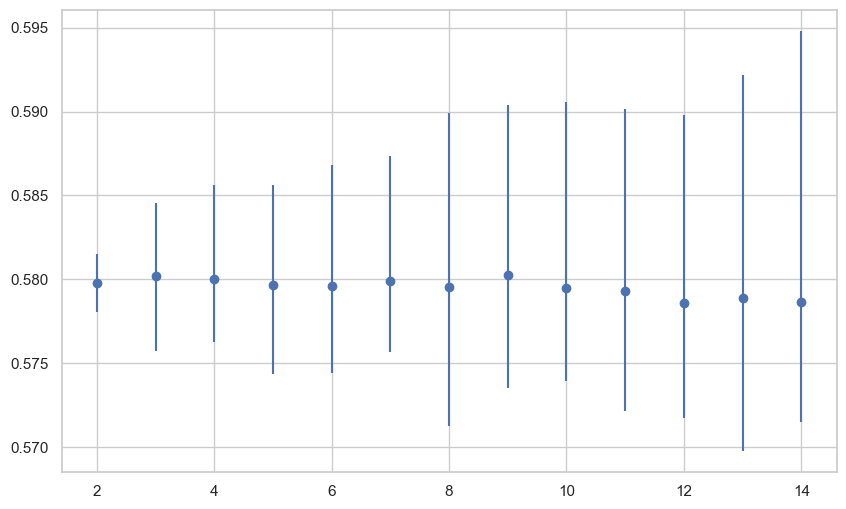

Evaluating folds: 100%|██████████| 13/13 [00:25<00:00,  2.00s/it]


The optimal folds for SGDClassifier is 10-fold with accuracy 0.6084 and range (0.4767, 0.7203)


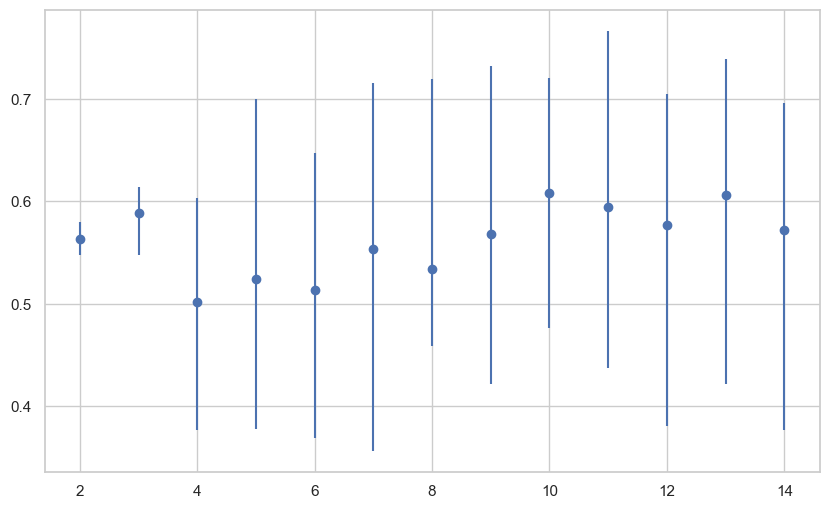

Evaluating folds: 100%|██████████| 13/13 [02:33<00:00, 11.77s/it]


The optimal folds for DecisionTreeClassifier is 2-fold with accuracy 0.9946 and range (0.9944, 0.9948)


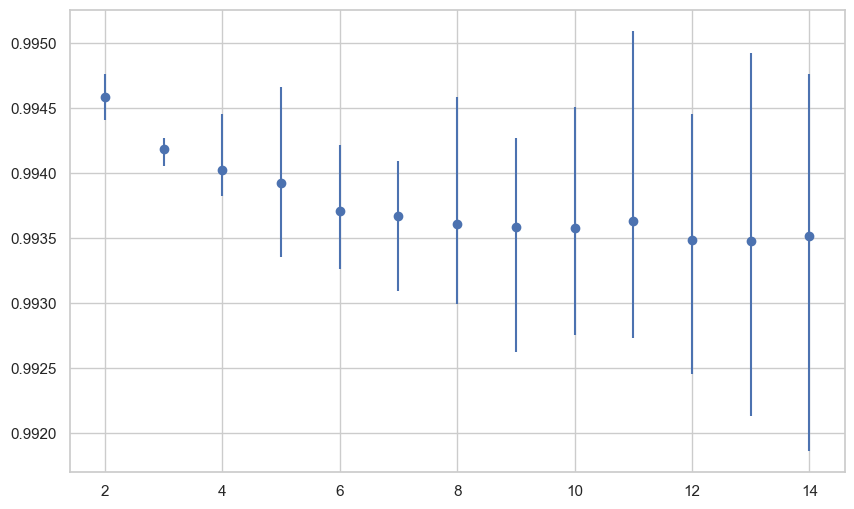

{'LogisticRegression': 9, 'SGDClassifier': 10, 'DecisionTreeClassifier': 2}


In [25]:
# Store optimal K values for any new classifier to test
optimal_k_dict = {}
kfold_eval(LogisticRegression, class_weight="balanced")
kfold_eval(SGDClassifier, loss='hinge',learning_rate = 'optimal', early_stopping = True, class_weight = 'balanced', max_iter = 1000)
kfold_eval(DecisionTreeClassifier, class_weight='balanced', random_state=42)
print(optimal_k_dict)

### Hyperparameter optimisation and search space dictionaries

In [ ]:
# Extended search spaces for different models
search_spaces = {
    "LogisticRegression": {
        "C": loguniform(1e-5, 100)
    },
    "SGDClassifier": {
        "penalty": ['l1', 'l2', 'elasticnet'],
        "alpha": [0.0001, 0.0005, 0.001, 0.005, 0.006, 0.01]
    },
    "DecisionTreeClassifier": {
        "criterion": ['gini', 'entropy'],
        "max_depth": randint(1, 11),
        "min_samples_split": randint(2, 15),
        "max_leaf_nodes": randint(5, 30)
    }
}
# For Logistic Regression Model
LR_model, LR_params = perform_search(
        search_spaces, 
        LogisticRegression, 
        X_train_processed, 
        y_train, 
        search_type='random', 
        default_cv=3,
        n_iter=100, 
        scoring='accuracy',
        class_weight='balanced', 
        random_state=42
    )
# For Stochastic Gradient Descent Model
SGD_model, SGD_params = perform_search(
    search_spaces, 
    SGDClassifier, 
    X_train_processed, 
    y_train, 
    search_type='random', 
    default_cv=3, 
    n_iter=100, 
    scoring='accuracy', 
    class_weight='balanced', 
    random_state=42, 
    loss='hinge',
    learning_rate = 'optimal', 
    early_stopping = True,  
    max_iter = 1000
    )
# For Decision Tree Model
DT_model, DT_params = perform_search(
    search_spaces, 
    DecisionTreeClassifier, 
    X_train_processed, 
    y_train, 
    search_type='random', 
    default_cv=3, 
    n_iter=100,
    scoring='accuracy', 
    class_weight='balanced', 
    random_state=42
    )

Best Score for LogisticRegression: 0.6091
Best Hyperparameters for LogisticRegression: {'C': 0.0007933105363733019}
Best Score for SGDClassifier: 0.7280
Best Hyperparameters for SGDClassifier: {'penalty': 'l1', 'alpha': 0.01}
Best Score for DecisionTreeClassifier: 0.5774
Best Hyperparameters for DecisionTreeClassifier: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_split': 4}


In [46]:
y_pred_LR = refit_and_evaluate(LogisticRegression, LR_params, X_train_processed, y_train, X_test_processed, y_test)
y_pred_SGD = refit_and_evaluate(SGDClassifier, SGD_params, X_train_processed, y_train, X_test_processed, y_test)
y_pred_DT = refit_and_evaluate(DecisionTreeClassifier, DT_params, X_train_processed, y_train, X_test_processed, y_test)

metrics_list = []
metrics_list.append(y_pred_LR)
metrics_list.append(y_pred_SGD)
metrics_list.append(y_pred_DT)

metrics_df = pd.DataFrame(metrics_list)

Accuracy score for LogisticRegression: 0.8317
Confusion Matrix for {model_name}:
 [[31352     0]
 [ 6344     0]]
Precision, Recall, F1-Score for {model_name}:
 (0.6917353392414988, 0.8317062818336163, 0.7552906774431566, None)
Classification Report for {model_name}:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91     31352
           1       0.00      0.00      0.00      6344

    accuracy                           0.83     37696
   macro avg       0.42      0.50      0.45     37696
weighted avg       0.69      0.83      0.76     37696

Accuracy score for SGDClassifier: 0.8317
Confusion Matrix for {model_name}:
 [[31352     0]
 [ 6344     0]]
Precision, Recall, F1-Score for {model_name}:
 (0.6917353392414988, 0.8317062818336163, 0.7552906774431566, None)
Classification Report for {model_name}:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91     31352
           1       0.00      0.00

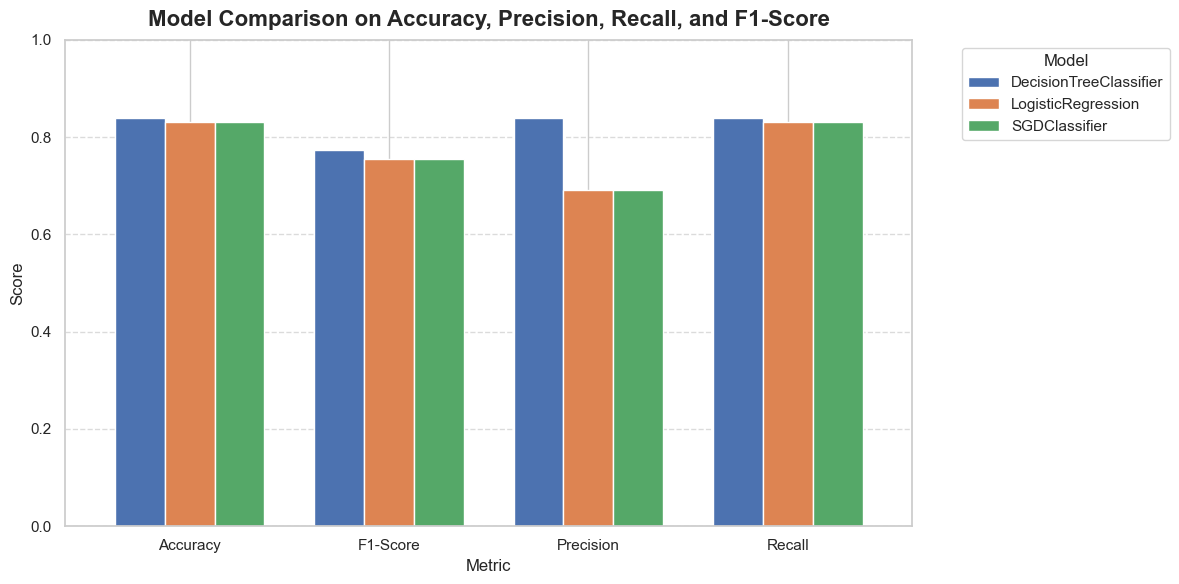

In [47]:

# Ensure "Model" is set as a column if not present
if 'Model' not in metrics_df.columns:
    metrics_df = metrics_df.reset_index().rename(columns={'index': 'Model'})

def plot_metrics_grouped(metrics_df):
    """
    Plot a comparison of accuracy, precision, recall, and F1-score for each model,
    with metrics as the x-axis and models as separate bars within each metric group.
    
    Parameters:
        - metrics_df: DataFrame with metrics for each model (one row per model)
    """
    # Melt the DataFrame to prepare for plotting
    metrics_df_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
    
    # Pivot the melted data
    pivot_df = metrics_df_melted.pivot(index="Metric", columns="Model", values="Score")

    # Plot the metrics grouped by model
    pivot_df.plot(kind="bar", figsize=(12, 6), width=0.75)
    plt.title("Model Comparison on Accuracy, Precision, Recall, and F1-Score", fontsize=16, fontweight="bold", pad=10, loc="center")
    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot the comparison
plot_metrics_grouped(metrics_df)